In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.fft as fft
import seaborn as sns
sns.set()

from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tqdm.notebook import tqdm

import sys
sys.path.append("/home/evangelos/workspace/Channel_Charting/")
from tools import utils
from src.models import supervised_classifier, supervised_regressor
from src.utils.data_preparation import SupervisedDataset

In [2]:
# load datasets
# load frequency data
(raw_taps, raw_phi, raw_theta, raw_rx_positions, raw_tx_positions) = utils.load_datasets()

In [3]:
#fourier transform and undersample taps
raw_freq_taps = fft.fft(raw_taps , workers=-1)[:,:,::2]

In [4]:
def preprocessing(data, first_data, rx_positions, padding=True):
    data = utils.drop_top_right(data, rx_positions)
    data = utils.standarize(data)
    data = utils.fillna(data)
    if padding:
        data = utils.zero_padding_as(data, first_data)
    #data = utils.take_norm(data)
    
    return data

In [5]:
taps = preprocessing(raw_freq_taps, raw_freq_taps, raw_rx_positions)
taps = np.hstack([np.real(taps), np.imag(taps)])

In [6]:
phi = preprocessing(raw_phi, taps, raw_rx_positions)

In [7]:
theta = preprocessing(raw_theta, taps, raw_rx_positions)

In [8]:
y  = preprocessing(raw_rx_positions, taps, raw_rx_positions, padding=False)[:,:2]

In [9]:
X = np.hstack([taps, phi[:-10], theta[:-10]])

In [10]:
#assign labels to certain areas of the map using kmeans
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4) 
km = km.fit(y)
labels = km.predict(y)

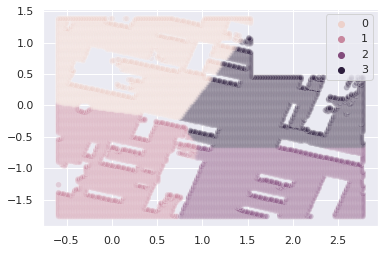

In [11]:
sns.scatterplot(y[:,0], y[:,1], hue=labels, alpha=0.3)

In [12]:
#train test split
train_X, test_X ,train_y, test_y, train_labels, test_labels = train_test_split(X, y, labels)
train_DS = SupervisedDataset(train_X, train_labels)
test_DS = SupervisedDataset(test_X, test_labels)

In [13]:
train_loader = DataLoader(train_DS, batch_size=32)
test_loader = DataLoader(test_DS)

In [14]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

model = supervised_classifier.Classifier(channels=train_DS.channels(), nb_labels=8)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [15]:
best_val_loss = 9999
count = 0
for epoch in tqdm(range(100)):
    loss = supervised_classifier.train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = supervised_classifier.test(model, test_loader, criterion, device)
    print("Training Loss: ", loss)
    print("Validation Loss: ", val_loss)
    print("Validation Accuracy: ", val_acc)

    if best_val_loss < val_loss:
        count += 1
    else:
        best_val_loss = val_loss
    if count > 5:
        break

Training Loss:  0.03253035199572381
Validation Loss:  0.8045829349030355
Validation Accuracy:  0.6613786591123701
Training Loss:  0.024153205412187573
Validation Loss:  0.7116739170986814
Validation Accuracy:  0.6870632672332389
Training Loss:  0.021795885834069155
Validation Loss:  0.6896909299427274
Validation Accuracy:  0.6976392823418319
Training Loss:  0.019990628825276968
Validation Loss:  0.6413861788743974
Validation Accuracy:  0.7265344664778093
Training Loss:  0.018988017196627655
Validation Loss:  0.598170214923764
Validation Accuracy:  0.7459867799811143
Training Loss:  0.01826718641920113
Validation Loss:  0.5817201082257649
Validation Accuracy:  0.746742209631728
Training Loss:  0.017381167339376467
Validation Loss:  0.5735060621581549
Validation Accuracy:  0.7595845136921624
Training Loss:  0.016631072892662652
Validation Loss:  0.5603223506642309
Validation Accuracy:  0.7669499527856468
Training Loss:  0.015701169107862904
Validation Loss:  0.5617575822149262
Validation

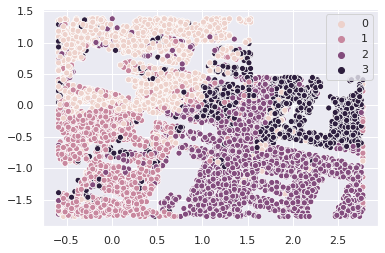

In [16]:
yhats = model(test_DS[:][0]).detach()
predictions = yhats.argmax(dim=1)
sns.scatterplot(test_y[:,0], test_y[:,1], hue=predictions)

In [17]:
print(classification_report(predictions, test_labels))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1325
           1       0.78      0.83      0.81      1206
           2       0.95      0.66      0.78      1859
           3       0.57      0.82      0.67       905

    accuracy                           0.78      5295
   macro avg       0.78      0.79      0.77      5295
weighted avg       0.81      0.78      0.78      5295



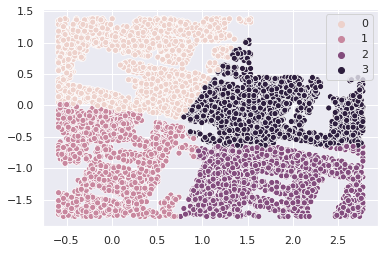

In [18]:
sns.scatterplot(test_y[:,0], test_y[:,1], hue=test_labels)

## Semi Supervised Learning

In [ ]:
X_sampled, X_remaining, y_sampled, y_remaining, labels_sampled, labels_remaining = train_test_split(train_X, train_y, train_labels, train_size=2500)
its = 0
while len(X_remaining)>2500:
    
    train_DS = SupervisedDataset(X_sampled, labels_sampled)
    train_loader = DataLoader(train_DS, batch_size=64, shuffle=True)
    cuda = torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")
    
    if its == 0:
        model = supervised_classifier.Classifier(channels=train_DS.channels(), nb_labels=8)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters())
    best_val_loss = 9999
    count=0
    
    for epoch in tqdm(range(10)):
        loss = supervised_classifier.train(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = supervised_classifier.test(model, test_loader, criterion, device)
        print("Training Loss: ", loss)
        print("Validation Loss: ", val_loss)
        print("Validation Accuracy: ", val_acc)

        if best_val_loss < val_loss:
            count += 1
        else:
            best_val_loss = val_loss
        if count > 5:
            break
            
    # add confident samples to training
    yhats = model(torch.Tensor(X_remaining))
    idces = (yhats.max(dim=1).values > torch.mean(yhats.max(dim=1).values) + 2*torch.std(yhats.max(dim=1).values))
    confident_X, confident_labels, confident_y = X_remaining[idces], yhats[idces].argmax(dim=1).detach().numpy(), y_remaining[idces]
    X_sampled = np.concatenate([X_sampled, confident_X])
    y_sampled = np.concatenate([y_sampled, confident_y])
    labels_sampled = np.concatenate([labels_sampled, confident_labels])
    X_remaining, labels_remaining, y_remaining = X_remaining[~idces], labels_remaining[~idces], y_remaining[~idces]
    
    print(len(X_remaining))
    its += 1

Training Loss:  0.025932685136795045
Validation Loss:  1.391916586330637
Validation Accuracy:  0.31312559017941455
Training Loss:  0.020862263536453245
Validation Loss:  1.279590544639273
Validation Accuracy:  0.3939565627950897
Training Loss:  0.019568199729919435
Validation Loss:  1.185434665525995
Validation Accuracy:  0.458356940509915
Training Loss:  0.01745914535522461
Validation Loss:  1.0774609651106979
Validation Accuracy:  0.5346553352219074
Training Loss:  0.015527203464508057
Validation Loss:  0.9947660265011999
Validation Accuracy:  0.5559962228517469
Training Loss:  0.014294288730621338
Validation Loss:  0.931024367813939
Validation Accuracy:  0.6075542965061379
Training Loss:  0.014071841502189637
Validation Loss:  0.9308906412877783
Validation Accuracy:  0.6047214353163362
Training Loss:  0.01301016503572464
Validation Loss:  0.8544970229624685
Validation Accuracy:  0.6381491973559962
Training Loss:  0.01254503321647644
Validation Loss:  0.9318358844485815
Validation Ac

Training Loss:  0.008867074791103144
Validation Loss:  0.7907025250018446
Validation Accuracy:  0.6649669499527856
Training Loss:  0.008469778250857447
Validation Loss:  0.818244160346383
Validation Accuracy:  0.6576015108593012
Training Loss:  0.008327970578963584
Validation Loss:  0.8540193909390081
Validation Accuracy:  0.6457034938621341
Training Loss:  0.008101534090230044
Validation Loss:  0.8440352413900688
Validation Accuracy:  0.6492917847025496
Training Loss:  0.007917627249429253
Validation Loss:  0.8040313667964971
Validation Accuracy:  0.6591123701605288
Training Loss:  0.0074424399671831985
Validation Loss:  0.8208795956937187
Validation Accuracy:  0.6642115203021719
Training Loss:  0.006991731913566291
Validation Loss:  0.8521514710275314
Validation Accuracy:  0.654957507082153
12239


Training Loss:  0.006186941346208822
Validation Loss:  0.8423280618620397
Validation Accuracy:  0.6593012275731822
Training Loss:  0.006292401362132816
Validation Loss:  0.8425536285996755
Validation Accuracy:  0.6613786591123701
Training Loss:  0.006094467279252839
Validation Loss:  0.8350732755773163
Validation Accuracy:  0.6700661000944287
Training Loss:  0.005489532521933023
Validation Loss:  0.8187060670219822
Validation Accuracy:  0.67780925401322
Training Loss:  0.005254713288875364
Validation Loss:  0.8887712616268674
Validation Accuracy:  0.6715769593956563
Training Loss:  0.005564452967842638
Validation Loss:  0.8754908864153697
Validation Accuracy:  0.6702549575070822
Training Loss:  0.005068464255784398
Validation Loss:  0.8674689396640212
Validation Accuracy:  0.67780925401322
Training Loss:  0.004920690368480661
Validation Loss:  0.9085214873658403
Validation Accuracy:  0.676109537299339
Training Loss:  0.004792385359430679
Validation Loss:  0.9151702949925605
Validation 

Training Loss:  0.003999018986349917
Validation Loss:  0.9379889429084055
Validation Accuracy:  0.6796978281397544
Training Loss:  0.0045469452518731674
Validation Loss:  0.9491810507285487
Validation Accuracy:  0.665533522190746
Training Loss:  0.004287898068039275
Validation Loss:  0.9872694407107695
Validation Accuracy:  0.6774315391879131
Training Loss:  0.004409888906429686
Validation Loss:  0.9594703954312311
Validation Accuracy:  0.6847969782813975
Training Loss:  0.004003786830635574
Validation Loss:  0.9443116701200103
Validation Accuracy:  0.6897072710103872
Training Loss:  0.003616686417310155
Validation Loss:  0.9530723514483945
Validation Accuracy:  0.7002832861189802
Training Loss:  0.0034966704777334586
Validation Loss:  1.008637044736531
Validation Accuracy:  0.6861189801699716
11661


Training Loss:  0.003184346435393049
Validation Loss:  0.9870557084364528
Validation Accuracy:  0.7061378659112371
Training Loss:  0.0038209039539677564
Validation Loss:  1.1038047544089733
Validation Accuracy:  0.6687440982058546
Training Loss:  0.004038429620959419
Validation Loss:  0.9497024577792816
Validation Accuracy:  0.7016052880075543
Training Loss:  0.0032914864090820557
Validation Loss:  1.0270616083665782
Validation Accuracy:  0.6961284230406043
Training Loss:  0.0031833262537918853
Validation Loss:  1.03968894503049
Validation Accuracy:  0.6880075542965062
Training Loss:  0.0032664108024367446
Validation Loss:  1.0361855155849624
Validation Accuracy:  0.67780925401322
Training Loss:  0.0033591207406253737
Validation Loss:  1.0836137123927354
Validation Accuracy:  0.6749763928234184
Training Loss:  0.0030651159093934514
Validation Loss:  1.063300331708916
Validation Accuracy:  0.6991501416430594
11381


Training Loss:  0.0026838634277332736
Validation Loss:  1.0628145789456471
Validation Accuracy:  0.7034938621340887
Training Loss:  0.002754100448208245
Validation Loss:  1.0927318838912863
Validation Accuracy:  0.7067044381491974
Training Loss:  0.002553700413579731
Validation Loss:  1.1137752074367304
Validation Accuracy:  0.6961284230406043
Training Loss:  0.0024399074478805567
Validation Loss:  1.1215256934536397
Validation Accuracy:  0.6970727101038716
Training Loss:  0.00255726345432885
Validation Loss:  1.128436122174386
Validation Accuracy:  0.7002832861189802
Training Loss:  0.0028025313536626188
Validation Loss:  1.1278781250713328
Validation Accuracy:  0.6766761095372993
Training Loss:  0.00287499183955218
Validation Loss:  1.1463020641794943
Validation Accuracy:  0.6358829084041548
11092


Training Loss:  0.003442799299644344
Validation Loss:  1.099648570300586
Validation Accuracy:  0.6793201133144476
Training Loss:  0.002837120617351659
Validation Loss:  1.1162381593963182
Validation Accuracy:  0.7014164305949009
Training Loss:  0.002823893815913496
Validation Loss:  1.1333271807094434
Validation Accuracy:  0.6895184135977337
Training Loss:  0.0025558037544573258
Validation Loss:  1.1893398229053485
Validation Accuracy:  0.693484419263456
Training Loss:  0.0024961257795467926
Validation Loss:  1.132789113714731
Validation Accuracy:  0.702738432483475
Training Loss:  0.002475470591797582
Validation Loss:  1.1559066533071916
Validation Accuracy:  0.7036827195467422
Training Loss:  0.002168479209337745
Validation Loss:  1.215165655922493
Validation Accuracy:  0.7061378659112371
10813


Training Loss:  0.0022495446954458893
Validation Loss:  1.1688237661665224
Validation Accuracy:  0.698961284230406
Training Loss:  0.0023230015283681937
Validation Loss:  1.1799123377022862
Validation Accuracy:  0.7031161473087819
Training Loss:  0.0020754471494718887
Validation Loss:  1.1814844120145915
Validation Accuracy:  0.6961284230406043
Training Loss:  0.0021334801177830386
Validation Loss:  1.2015301644936887
Validation Accuracy:  0.7084041548630784
Training Loss:  0.0020117362946477633
Validation Loss:  1.2672381197902025
Validation Accuracy:  0.6987724268177526
Training Loss:  0.0020332943167743187
Validation Loss:  1.2987039676520353
Validation Accuracy:  0.667610953729934
Training Loss:  0.0023317711672434975
Validation Loss:  1.230721970259492
Validation Accuracy:  0.702738432483475
10607


Training Loss:  0.002067277135950223
Validation Loss:  1.29507466074129
Validation Accuracy:  0.6997167138810199
Training Loss:  0.001965267034395795
Validation Loss:  1.300715006411095
Validation Accuracy:  0.7038715769593956
Training Loss:  0.001888399895695776
Validation Loss:  1.2330719349887582
Validation Accuracy:  0.7076487252124646
Training Loss:  0.001740614077961743
Validation Loss:  1.33832905940287
Validation Accuracy:  0.6982058545797922
Training Loss:  0.0018940623909647354
Validation Loss:  1.3208761012333337
Validation Accuracy:  0.7006610009442871
Training Loss:  0.0020764318977604767
Validation Loss:  1.3363144935745261
Validation Accuracy:  0.7078375826251181
Training Loss:  0.0020029529946107047
Validation Loss:  1.2267252954307482
Validation Accuracy:  0.7138810198300283
Training Loss:  0.0016741433189341613
Validation Loss:  1.3510998671102845
Validation Accuracy:  0.6985835694050991
Training Loss:  0.001907943071863862
Validation Loss:  1.2405686396282771
Validat

Training Loss:  0.0017900563810578074
Validation Loss:  1.239094833285455
Validation Accuracy:  0.7114258734655335
Training Loss:  0.0014570293758247631
Validation Loss:  1.3571392976094985
Validation Accuracy:  0.704438149197356
Training Loss:  0.0014421497052251374
Validation Loss:  1.2849456929400251
Validation Accuracy:  0.7152030217186025
Training Loss:  0.0013300594705807605
Validation Loss:  1.2925726994051132
Validation Accuracy:  0.7152030217186025
Training Loss:  0.0012238929233643096
Validation Loss:  1.361528891210522
Validation Accuracy:  0.7201133144475921
Training Loss:  0.001364895785217393
Validation Loss:  1.5480137884867395
Validation Accuracy:  0.6711992445703494
Training Loss:  0.002236659664189183
Validation Loss:  1.3392636579068737
Validation Accuracy:  0.693484419263456
10105


Training Loss:  0.002164270300721165
Validation Loss:  1.2328881287244906
Validation Accuracy:  0.7153918791312559
Training Loss:  0.0016988917086602248
Validation Loss:  1.2982265608520918
Validation Accuracy:  0.702738432483475
Training Loss:  0.0015234392430980175
Validation Loss:  1.275920971847815
Validation Accuracy:  0.7131255901794146
Training Loss:  0.0015037914821230114
Validation Loss:  1.2735464395627092
Validation Accuracy:  0.7152030217186025
Training Loss:  0.0015638026935278894
Validation Loss:  1.3193839475020932
Validation Accuracy:  0.7074598677998112
Training Loss:  0.0017058309357015009
Validation Loss:  1.275812691169448
Validation Accuracy:  0.715014164305949
Training Loss:  0.0016339938551208147
Validation Loss:  1.3028441349465207
Validation Accuracy:  0.7057601510859302
9811


Training Loss:  0.0016856195987355607
Validation Loss:  1.3511200033637498
Validation Accuracy:  0.7031161473087819
Training Loss:  0.0015626866579036152
Validation Loss:  1.3149528569661468
Validation Accuracy:  0.7046270066100094
Training Loss:  0.0013992218127380934
Validation Loss:  1.4160672370230287
Validation Accuracy:  0.7093484419263456
Training Loss:  0.0011861760110063024
Validation Loss:  1.450634202823354
Validation Accuracy:  0.7082152974504249
Training Loss:  0.0012186364626894767
Validation Loss:  1.5203591950375974
Validation Accuracy:  0.6598677998111426
Training Loss:  0.001268119155061192
Validation Loss:  1.521122550804235
Validation Accuracy:  0.6948064211520302
Training Loss:  0.0014036372475748162
Validation Loss:  1.4555462435652355
Validation Accuracy:  0.6893295561850803
Training Loss:  0.0016849961411576026
Validation Loss:  1.3768140664331547
Validation Accuracy:  0.7025495750708215
9555


Training Loss:  0.0012692129542252258
Validation Loss:  1.4483053897356224
Validation Accuracy:  0.71123701605288
Training Loss:  0.0012527098365577806
Validation Loss:  1.4620465185910834
Validation Accuracy:  0.7119924457034938
Training Loss:  0.0014825085302086032
Validation Loss:  1.3936967199956167
Validation Accuracy:  0.6999055712936733
Training Loss:  0.0013247612329828642
Validation Loss:  1.5184144918330946
Validation Accuracy:  0.6932955618508027
Training Loss:  0.0012261148619579737
Validation Loss:  1.3760477414662509
Validation Accuracy:  0.7123701605288008
Training Loss:  0.0010719195087163624
Validation Loss:  1.6344446303435383
Validation Accuracy:  0.6874409820585458
Training Loss:  0.0012681678206248942
Validation Loss:  1.5387431049110198
Validation Accuracy:  0.7017941454202078
Training Loss:  0.0011873237361722919
Validation Loss:  1.424911473818113
Validation Accuracy:  0.7038715769593956
Training Loss:  0.0011076645907943281
Validation Loss:  1.510147533142531
V

Training Loss:  0.001034102401170055
Validation Loss:  1.5944646033108547
Validation Accuracy:  0.699338999055713
Training Loss:  0.0010211948453242542
Validation Loss:  1.5221368402331945
Validation Accuracy:  0.709537299338999
Training Loss:  0.0010978288164731997
Validation Loss:  1.5629919411647744
Validation Accuracy:  0.7087818696883853
Training Loss:  0.0009703733013917955
Validation Loss:  1.5709305823283564
Validation Accuracy:  0.7070821529745043
Training Loss:  0.0009288030313256815
Validation Loss:  1.6022622495350562
Validation Accuracy:  0.7068932955618508
Training Loss:  0.0008537387849222282
Validation Loss:  1.651460952907372
Validation Accuracy:  0.7106704438149197
Training Loss:  0.000911026943762936
Validation Loss:  1.6631346640969447
Validation Accuracy:  0.7084041548630784
Training Loss:  0.000894831167925007
Validation Loss:  1.6606398274345593
Validation Accuracy:  0.7174693106704438
9148


Training Loss:  0.0010451930081128691
Validation Loss:  1.6440781614338227
Validation Accuracy:  0.7140698772426818
Training Loss:  0.0013341789124339941
Validation Loss:  1.4521936929347845
Validation Accuracy:  0.7048158640226629
Training Loss:  0.001404804348221025
Validation Loss:  1.4869285466436815
Validation Accuracy:  0.7025495750708215
Training Loss:  0.001409624619845027
Validation Loss:  1.4764121865210338
Validation Accuracy:  0.7038715769593956
Training Loss:  0.00115473929214628
Validation Loss:  1.5058334918854415
Validation Accuracy:  0.7099150141643059
Training Loss:  0.000987651286426857
Validation Loss:  1.4993176198697595
Validation Accuracy:  0.7180358829084041
Training Loss:  0.0008429929984055194
Validation Loss:  1.5580134880487522
Validation Accuracy:  0.6827195467422096
Training Loss:  0.0008861536790327111
Validation Loss:  1.5759049540327794
Validation Accuracy:  0.7180358829084041
8916


Training Loss:  0.0007944021608455376
Validation Loss:  1.6259612653227014
Validation Accuracy:  0.713314447592068
Training Loss:  0.0007858436491140686
Validation Loss:  1.682165777842629
Validation Accuracy:  0.7172804532577903
Training Loss:  0.0007508529926648822
Validation Loss:  1.672271891854101
Validation Accuracy:  0.7106704438149197
Training Loss:  0.0007092302173820691
Validation Loss:  1.6656753254449517
Validation Accuracy:  0.7172804532577903
Training Loss:  0.0010191001473506666
Validation Loss:  1.600483834827268
Validation Accuracy:  0.7129367327667611
Training Loss:  0.0008696274181489167
Validation Loss:  1.6717016416907562
Validation Accuracy:  0.7138810198300283
Training Loss:  0.0009096230567250204
Validation Loss:  1.7573516824394955
Validation Accuracy:  0.6999055712936733
Training Loss:  0.0011679176388203337
Validation Loss:  1.5079684852773743
Validation Accuracy:  0.7099150141643059
Training Loss:  0.0012120360336653451
Validation Loss:  1.462829541396075
Va

Training Loss:  0.0009991429635394728
Validation Loss:  1.5910130006183587
Validation Accuracy:  0.7004721435316336
Training Loss:  0.00115362884515586
Validation Loss:  1.6020240501680207
Validation Accuracy:  0.6980169971671388
Training Loss:  0.0010159579751941946
Validation Loss:  1.6554769505360287
Validation Accuracy:  0.7017941454202078
Training Loss:  0.0009381955387329475
Validation Loss:  1.5554560217933608
Validation Accuracy:  0.7121813031161474
Training Loss:  0.0007841904339794483
Validation Loss:  1.681147250588497
Validation Accuracy:  0.7051935788479697
Training Loss:  0.0014114722606609576
Validation Loss:  1.4794230301300964
Validation Accuracy:  0.6932955618508027
Training Loss:  0.0010962898885676017
Validation Loss:  1.5026972997725445
Validation Accuracy:  0.7159584513692162
Training Loss:  0.0007122694209263298
Validation Loss:  1.6053593750544155
Validation Accuracy:  0.7140698772426818
Training Loss:  0.0007400259948594288
Validation Loss:  1.6414612987564066


In [ ]:
yhats = model(test_DS[:][0]).detach().argmax(dim=1)

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.scatterplot(test_y[:,0], test_y[:,1], hue=yhats, legend="full", palette='gnuplot')
plt.subplot(1,2,2)
sns.scatterplot(test_y[:,0], test_y[:,1], hue=test_labels, legend="full", palette='gnuplot')

In [ ]:
print(classification_report(yhats, test_labels))

In [ ]:
sns.clustermap(confusion_matrix(yhats, test_labels), cmap='Blues')